## Real-Time Script
Historical Data Date Range - exact 12 months back from today


Analaysis Data Date Range - today

### For one currency pair - USDCHF

In [1]:
import requests
import pandas as pd

def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

def update_outliers_list(current_df, historical_outliers_df, real_time_outliers_df, n=10):
    if 'source' not in current_df.columns:
        current_df['source'] = 'real-time'
    combined_df = pd.concat([historical_outliers_df, current_df])
    updated_outliers_df = combined_df.nlargest(n, 'abs_daily_return')
    updated_historical_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'historical']
    updated_real_time_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'real-time']
    return updated_historical_outliers_df, updated_real_time_outliers_df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df

# API key and endpoints
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'
today = pd.Timestamp.now().date()
start_date = today - pd.DateOffset(years=1)
start_date_formatted = start_date.strftime('%Y-%m-%d')
end_date = today - pd.DateOffset(days=1)
end_date_formatted = end_date.strftime('%Y-%m-%d')
symbol = 'C:USDCHF'
historical_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date_formatted}/{end_date_formatted}?adjusted=true&sort=asc&apiKey={api_key}'
real_time_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{today}/{today}?adjusted=true&sort=asc&apiKey={api_key}'

# Fetch and process historical data
historical_data = fetch_data(historical_url)
if historical_data:
    historical_df = pd.DataFrame(historical_data['results'])
    historical_df = convert_timestamps(historical_df)
    historical_df = calculate_daily_returns(historical_df)
    historical_df['source'] = 'historical'
    historical_outliers_df = get_top_outliers(historical_df)
else:
    print("Failed to fetch or process historical data.")

# Fetch and process real-time data
real_time_data = fetch_data(real_time_url)
if real_time_data and 'results' in real_time_data:
    real_time_df = pd.DataFrame(real_time_data['results'])
    real_time_df = convert_timestamps(real_time_df)
    # Use the last close from historical data
    last_close = historical_df['c'].iloc[-1] if not historical_df.empty else None
    real_time_df = calculate_daily_returns(real_time_df, prev_close=last_close)
    real_time_df['source'] = 'real-time'
    updated_historical_outliers_df, updated_real_time_outliers_df = update_outliers_list(real_time_df, historical_outliers_df, pd.DataFrame())
    # Update historical data
    historical_df = pd.concat([historical_df.iloc[1:], real_time_df])  # Keep historical data rolling
else:
    print("No new data available or failed to fetch real-time data.")
    
# Combine data for Top 10 Outliers
full_outlier_df = pd.concat([updated_historical_outliers_df, updated_real_time_outliers_df])

# Print the Outliers
full_outlier_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
11,193037,0.8735,0.87876,0.866590,0.87923,0.86580,193037,2023-07-12,0.87875,-0.013838,0.013838,historical
250,187960,0.8932,0.88558,0.897500,0.89937,0.88360,187960,2024-03-21,0.88555,0.013494,0.013494,historical
134,168024,0.8965,0.90127,0.889100,0.90271,0.88750,168024,2023-11-14,0.90120,-0.013427,0.013427,historical
218,191642,0.8825,0.87580,0.887420,0.88810,0.87520,191642,2024-02-13,0.87581,0.013256,0.013256,historical
177,174820,0.8495,0.85359,0.842500,0.85487,0.84060,174820,2023-12-27,0.85372,-0.013142,0.013142,historical
267,159390,0.9089,0.90297,0.913140,0.91470,0.90260,159390,2024-04-10,0.90303,0.011196,0.011196,historical
310,172177,0.9074,0.91319,0.903320,0.91408,0.90053,172177,2024-05-30,0.91311,-0.010722,0.010722,historical
209,184263,0.8610,0.85760,0.866698,0.86820,0.85510,184263,2024-02-02,0.85760,0.010609,0.010609,historical
19,181573,0.8609,0.85794,0.866230,0.86839,0.85580,181573,2023-07-20,0.85770,0.009945,0.009945,historical
284,180821,0.9142,0.91075,0.919590,0.91965,0.91020,180821,2024-04-30,0.91072,0.009740,0.009740,historical


### Visualizing the Outliers

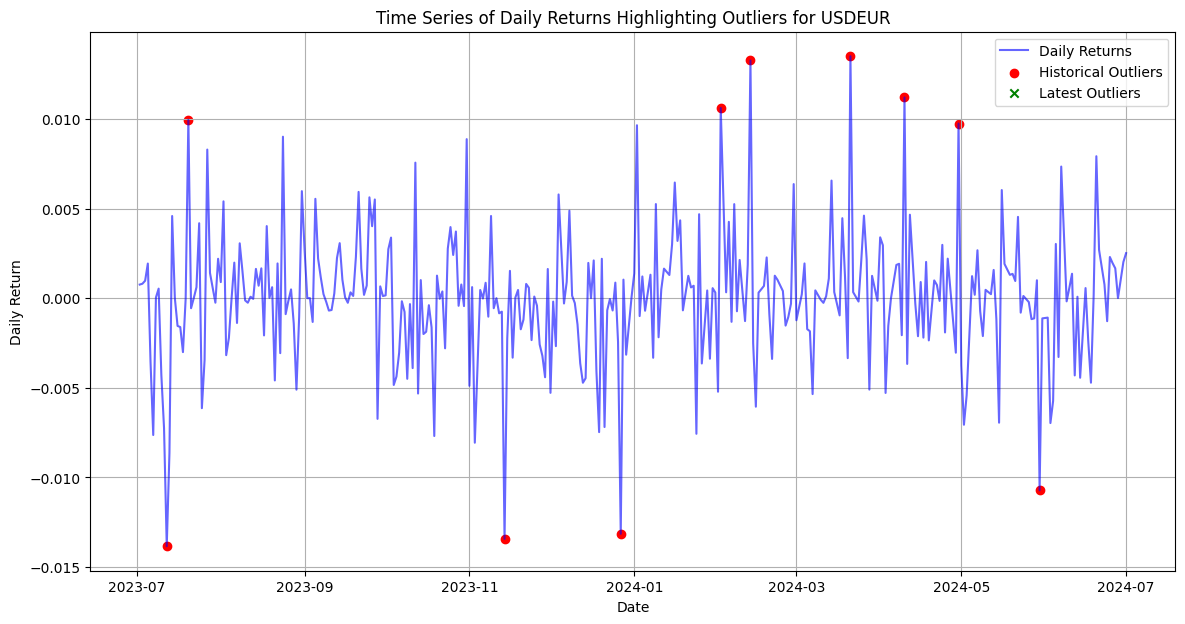

In [2]:
import matplotlib.pyplot as plt

def plot_data_with_outliers(historical_df, historical_outliers_df, real_time_outliers_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df['date'], historical_df['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(historical_outliers_df['date'], historical_outliers_df['daily_return'], color='red', label='Historical Outliers')
    plt.scatter(real_time_outliers_df['date'], real_time_outliers_df['daily_return'], color='green', label='Latest Outliers', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDEUR')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(historical_df, updated_historical_outliers_df, updated_real_time_outliers_df)

### Data Augmentation

In [3]:
def mark_outliers(historical_df, outliers_df):
    historical_df['outlier'] = 0
    outlier_dates = outliers_df['date'].values
    historical_df.loc[historical_df['date'].isin(outlier_dates), 'outlier'] = 1
    return historical_df

full_data_df = mark_outliers(historical_df, pd.concat([updated_historical_outliers_df, updated_real_time_outliers_df]))

full_data_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source,outlier
1,3238,0.8950,0.89490,0.895180,0.89530,0.89354,3238,2023-07-02,0.894503,0.000757,0.000757,historical,0
2,159519,0.8970,0.89518,0.895900,0.90041,0.89380,159519,2023-07-03,0.895180,0.000804,0.000804,historical,0
3,121274,0.8961,0.89583,0.896770,0.89760,0.89430,121274,2023-07-04,0.895900,0.000971,0.000971,historical,0
4,123051,0.8978,0.89662,0.898500,0.89950,0.89590,123051,2023-07-05,0.896770,0.001929,0.001929,historical,0
5,154047,0.8970,0.89852,0.895300,0.89976,0.89460,154047,2023-07-06,0.898500,-0.003561,0.003561,historical,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,147967,0.8966,0.89542,0.897030,0.89830,0.89430,147967,2024-06-26,0.895280,0.001955,0.001955,historical,0
334,147731,0.8973,0.89704,0.898520,0.89888,0.89550,147731,2024-06-27,0.897030,0.001661,0.001661,historical,0
335,149653,0.8991,0.89853,0.898526,0.90097,0.89770,149653,2024-06-28,0.898520,0.000007,0.000007,historical,0
336,3218,0.8997,0.89711,0.900340,0.90040,0.89711,3218,2024-06-30,0.898526,0.002019,0.002019,historical,0


In [4]:
# full_data_df.to_csv("Outlier Dataset.csv")

### Data Augmentation

Epoch 1/150


/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1843  
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0915 
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8479 
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8314 
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9577 
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8188 
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8519 
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7609 
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6173 
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7360 
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7538 
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5954 
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6294 
Epoch 14/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5096 
Epoch 15/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5635 
Epoch 16/150
4/4 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8178  
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7859 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7708 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7181 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7024 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6851 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6556 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6045 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6073 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5463 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5552 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5319 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4972 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4598 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4369 
Epoch 16/150
3/3 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1582  
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0754 
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0673 
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9363 
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8725 
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8635 
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7875 
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7634 
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7160 
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6363 
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5457 
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5099 
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4804 
Epoch 14/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4474 
Epoch 15/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3581 
Epoch 16/150
4/4 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0596  
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0549 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0304 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0403 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9030 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9091 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9326 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8225 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9132 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7009 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7498 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6697 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6392 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6350 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6631 
Epoch 16/150
3/3 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9802  
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0231 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9441 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8736 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8666 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8249 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7548 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8086 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7487 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7313 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6997 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6890 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6757 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6201 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5708 
Epoch 16/150
3/3 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8227
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7737 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7274 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6861 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6563 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6205 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5620 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5222 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4666 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4484 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3887 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3494 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3135 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2660 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2389 
Epoch 16/150
3/3 ━━━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8624  
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8661 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6978 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7748 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6669 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7054 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6921 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7028 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6210 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6069 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6212 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6329 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4673 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4568 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4703 
Epoch 16/150
3/3 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0182  
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0124 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0452 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8964 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9431 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9261 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8842 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8108 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7529 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7295 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6713 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7197 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6201 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5794 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5414 
Epoch 16/150
3/3 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0164  
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0392 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9594 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9084 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8825 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8709 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7794 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7707 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7335 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6952 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6515 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6343 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5799 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5261 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5184 
Epoch 16/150
3/3 ━━━━━━━━━━━━━

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_56892/3098541060.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data.fillna(method='ffill', inplace=True)  # forward fill
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9609  
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7674 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7947 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7593 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7897 
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6173 
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6222 
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7306 
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5778 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5226 
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5045 
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4905 
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4513 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4795 
Epoch 16/150
3/3 ━━━━━━━━━━━━━

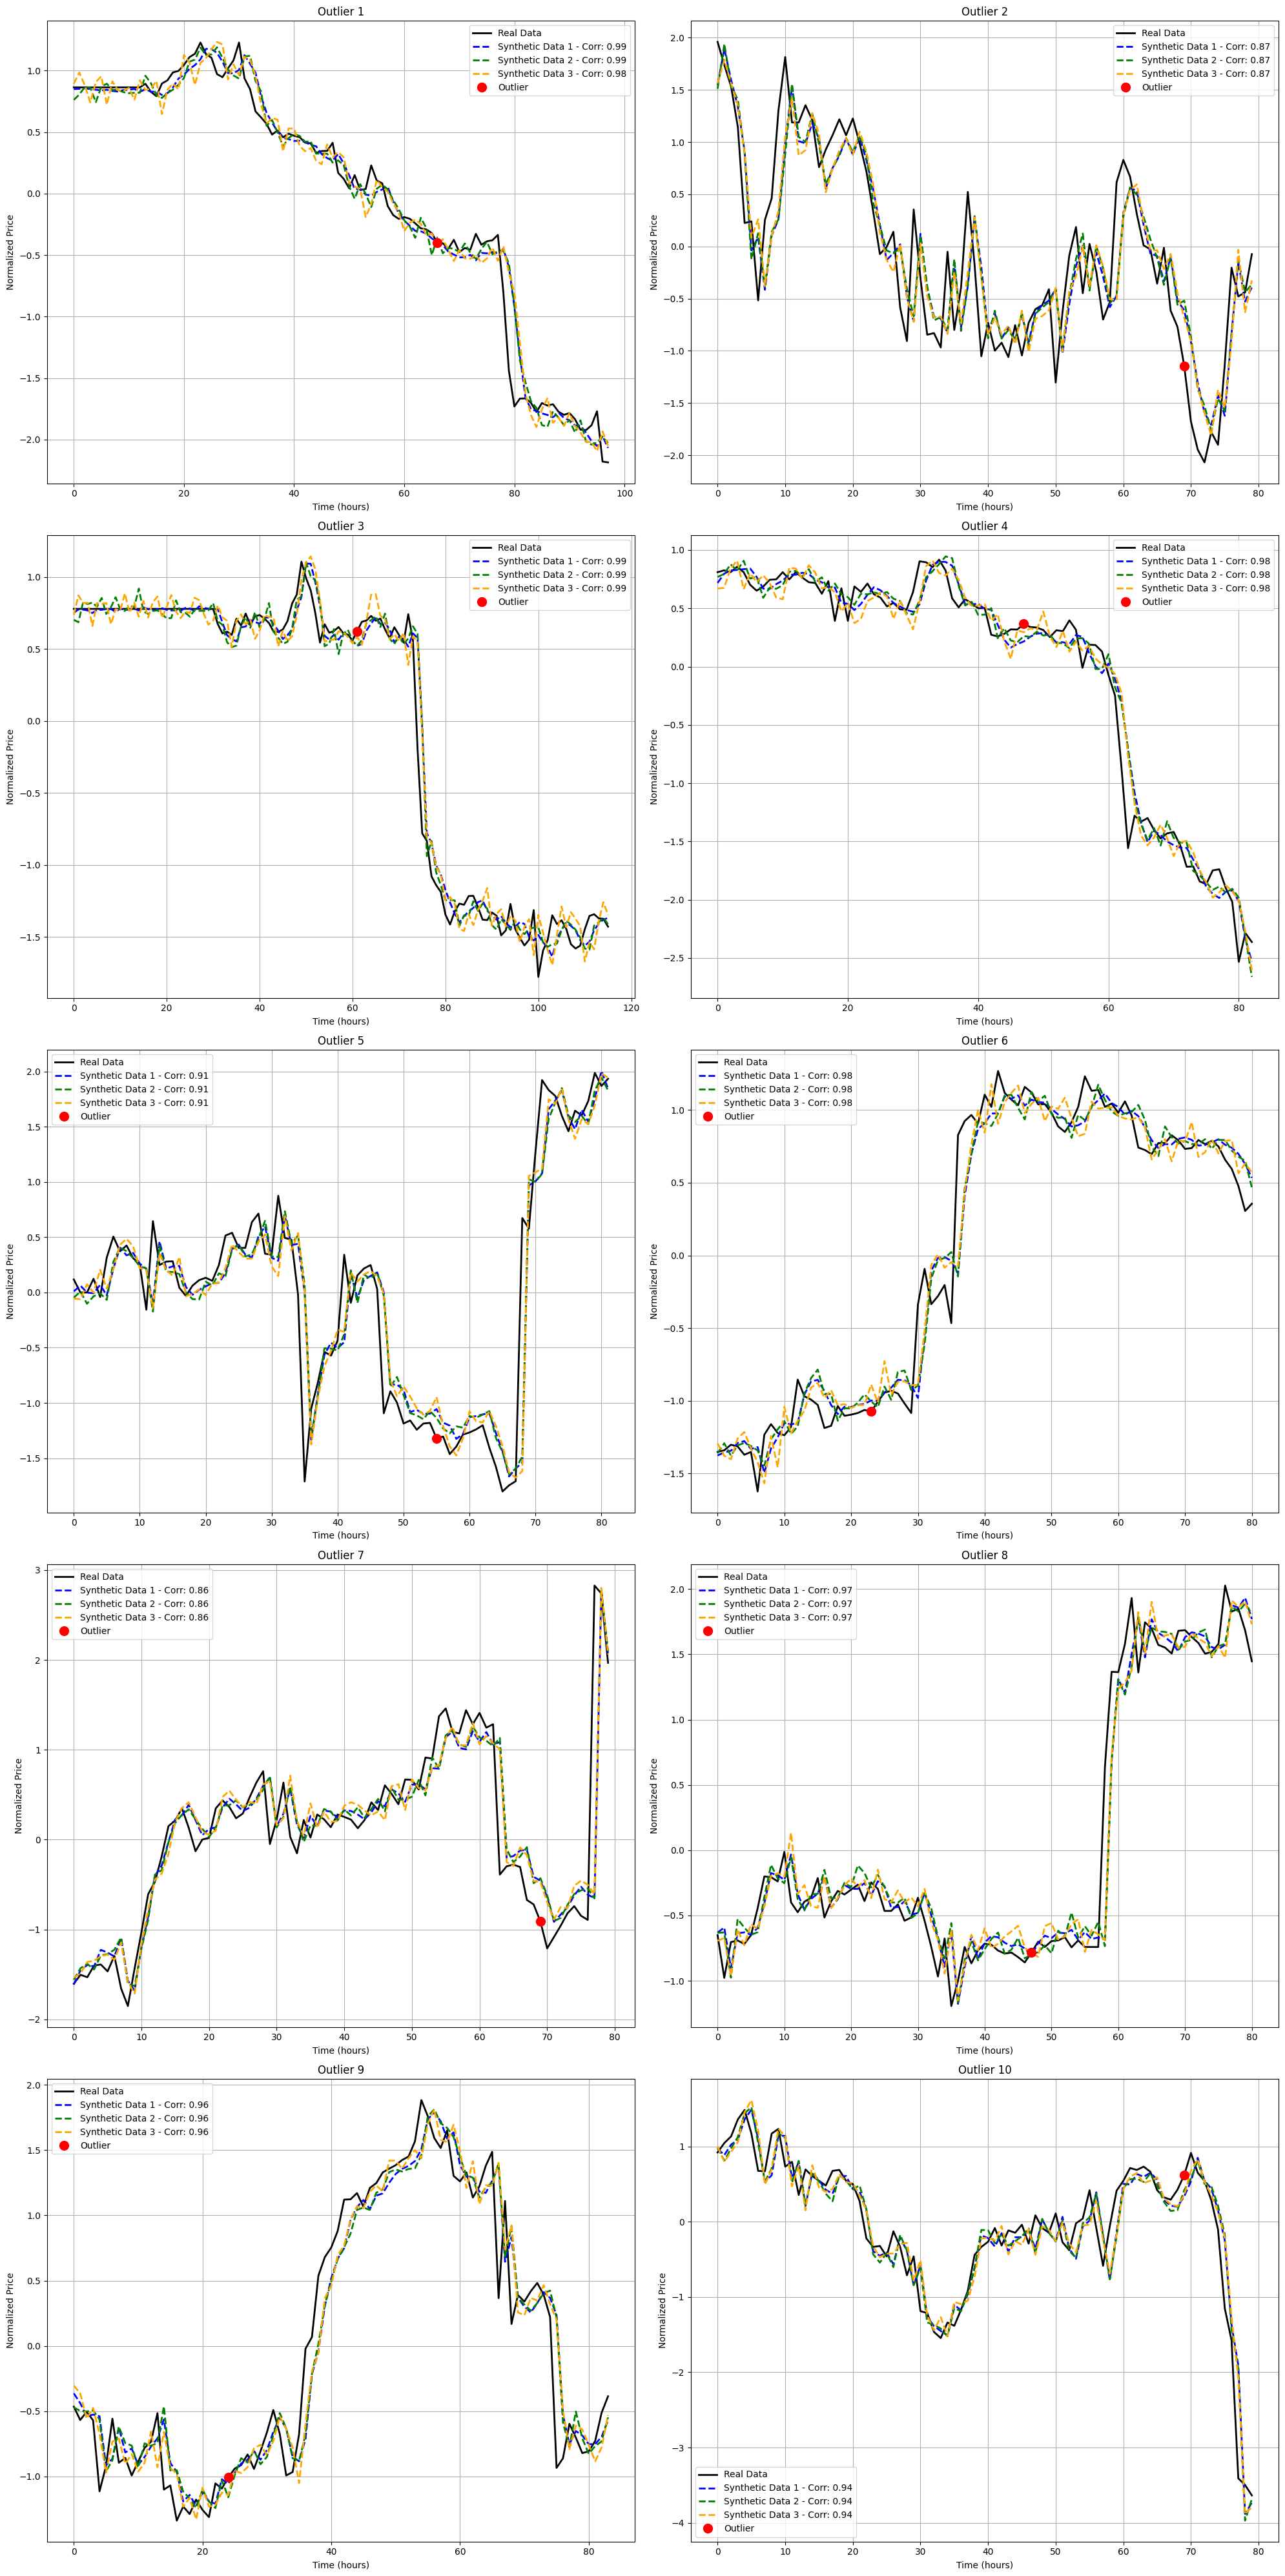

In [5]:
import pandas as pd
import requests
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def fetch_hourly_data(symbol, start_date, end_date, api_key):
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{start_date}/{end_date}?apiKey={api_key}"
    response = requests.get(url)
    hourly_data = pd.DataFrame(response.json()['results'])
    hourly_data['date'] = pd.to_datetime(hourly_data['t'], unit='ms')
    hourly_data.drop(columns=['t'], inplace=True)   
    return hourly_data

# Load the dataset
full_data_df['date'] = pd.to_datetime(full_data_df['date'])

# Filter rows where 'outlier' is 1
outliers = full_data_df[full_data_df['outlier'] == 1]

# Generate date ranges for each outlier
date_ranges = pd.DataFrame({
    "start_date": outliers['date'] - timedelta(days=3),
    "end_date": outliers['date'] + timedelta(days=3),
    "outlier_date": outliers['date']
})


# Plotting setup
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 40))
axs = axs.flatten()

# DataFrames to store results
df_real = pd.DataFrame()
df_synthetic_1 = pd.DataFrame()
df_synthetic_2 = pd.DataFrame()
df_synthetic_3 = pd.DataFrame()

# Process each date range
for idx, (ax, (_, row)) in enumerate(zip(axs, date_ranges.iterrows())):
    hourly_data = fetch_hourly_data(symbol, row['start_date'].date(), row['end_date'].date(), api_key)
    
    # Fill missing values
    hourly_data.fillna(method='ffill', inplace=True)  # forward fill

    # Normalize data
    scaler = StandardScaler()
    hourly_data[['v', 'vw', 'o', 'c', 'h', 'l']] = scaler.fit_transform(hourly_data[['v', 'vw', 'o', 'c', 'h', 'l']])

    # Prepare data for LSTM
    n_features = 1
    n_timesteps = 3  # Number of timesteps per sequence
    X = []
    y = []

    for i in range(n_timesteps, len(hourly_data)):
        X.append(hourly_data[['c']].iloc[i-n_timesteps:i].values)
        y.append(hourly_data['c'].iloc[i])

    X = np.array(X)
    y = np.array(y)

    # Build and fit LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=150, verbose=1)

    # Generate synthetic data with different noise types
    synthetic_data = []
    noises = [0.01, 0.05, 0.07]  # Different standard deviations for noise
    correlations = []
    for j, noise in enumerate(noises):
        predicted = model.predict(X)
        noise_data = np.random.normal(0, noise, predicted.shape)
        synthetic = predicted + noise_data
        synthetic_data.append(synthetic)
        
        # Calculate correlation
        correlation, _ = pearsonr(y, synthetic.flatten())
        correlations.append(correlation)

    # Store real and synthetic data
    df_real = pd.concat([df_real, pd.DataFrame(y, columns=[f'real_data_{idx+1}'])])
    df_synthetic_1 = pd.concat([df_synthetic_1, pd.DataFrame(synthetic_data[0], columns=[f'synthetic_1_{idx+1}'])])
    df_synthetic_2 = pd.concat([df_synthetic_2, pd.DataFrame(synthetic_data[1], columns=[f'synthetic_2_{idx+1}'])])
    df_synthetic_3 = pd.concat([df_synthetic_3, pd.DataFrame(synthetic_data[2], columns=[f'synthetic_3_{idx+1}'])])

    # Plotting
    real_data = hourly_data['c'].iloc[n_timesteps:].values
    ax.plot(real_data, label='Real Data', color='black', linewidth=2)
    colors = ['blue', 'green', 'orange']
    for k, data in enumerate(synthetic_data):
        ax.plot(data.flatten(), label=f'Synthetic Data {k+1} - Corr: {correlations[k]:.2f}', color=colors[k], linestyle='--', linewidth=2)
    outlier_index = hourly_data.index[hourly_data['date'] == row['outlier_date']]
    if not outlier_index.empty:
        ax.plot(outlier_index[0] - n_timesteps, real_data[outlier_index[0] - n_timesteps], 'ro', markersize=10, label='Outlier')
    ax.set_title(f'Outlier {idx + 1}')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Normalized Price')
    ax.legend()
    ax.grid(True)

# Display all the plots
plt.tight_layout()
plt.show()